In [82]:
%matplotlib notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import os

from load_data import *
from transformation import *
from map import *
import cv2
from pr2_utils import *
from map_utils import *
from motion_utils import *
from particle import *

In [92]:
# get data
data_path = "../data/"
data_version = 20
encoder_file_name = f"Encoders{data_version}.npz"
lidar_file_name = f"Hokuyo{data_version}.npz"
imu_file_name = f"Imu{data_version}.npz"

data = getData(data_path, encoder_file_name, lidar_file_name, imu_file_name)

In [93]:
# plot map with first laser scan
pose = { 'x': 0.0, 'y': 0.0, 'theta': 0.0 }
xlim = (-30,30)
ylim = (-30,30)
Map = OccupancyMap(xlim=xlim, ylim=ylim, res=0.2)
Map.mapping(data['lidar'], 0, pose)
# Map = mapInit(res=0.1)
# Map['map'] = mapping(Map['map'], data['lidar'], 0, pose, Map['res'])


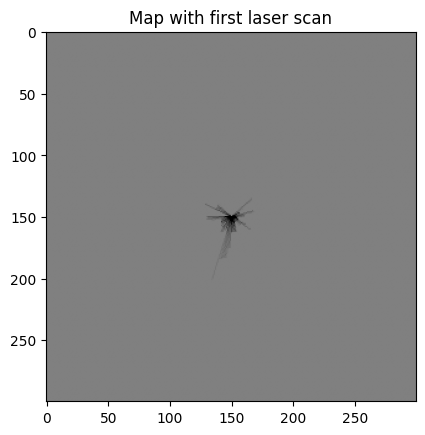

In [94]:
# plt.imshow(Map['map'], cmap='gray',vmin=-100, vmax=100)
plt.imshow(Map.grid, cmap='gray',vmin=-100, vmax=100)
plt.title("Map with first laser scan")
plt.savefig(f"../fig/first_{data_version}")

In [95]:
data_aligned = alignDataWithTime(data)

In [96]:
robot_pose = getOdometry(data_aligned)

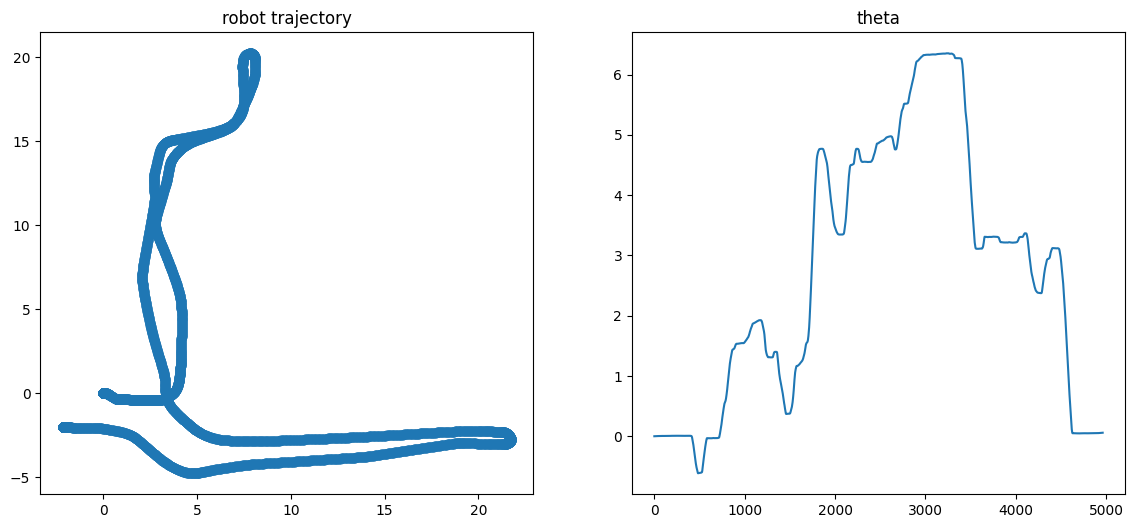

In [97]:
traj = robot_pose[:,:2]
fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
plt.scatter(traj[:,0], traj[:,1])
plt.title("robot trajectory")

ax2 = fig.add_subplot(122)
plt.plot(robot_pose[:,2])
plt.title("theta")
plt.savefig(f"../fig/traj_{data_version}")

In [98]:
from particle import Particle
P = Particle(num=64)
step_size = 20
trajectory = np.empty(shape=(1,2))
var_scale = np.array([0.001, 0.001, 0.01*np.pi/180])

In [99]:
lidar_data = data['lidar']
for i in range(0, len(lidar_data['lidar_ranges']), step_size):
    if(i%100==0): 
        print(i)
    ''' Predict '''
    delta_pose = getRelativeMotion(robot_pose, i, step_size)
    P.states = motionModelPrediction(P.states, delta_pose, var_scale)

    # ''' Update '''
    best_particle = measurement_model_update(Map, P, lidar_data, i)
    trajectory = np.vstack((trajectory, [int(best_particle[0] / Map.res) + Map.xsize // 2, int(best_particle[1] / Map.res) + Map.ysize // 2]))

    # ''' Mapping '''
    best_pose = { 'x': best_particle[0], 'y': best_particle[1], 'theta': best_particle[2] }
    Map.mapping(lidar_data, i, best_pose)

    # ''' Resample '''
    N_eff = 1 / np.sum(P.weight ** 2)
    if N_eff < 0.3 * P.num:
        print("Resampling...")
        P.resampling()
        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


Plot...


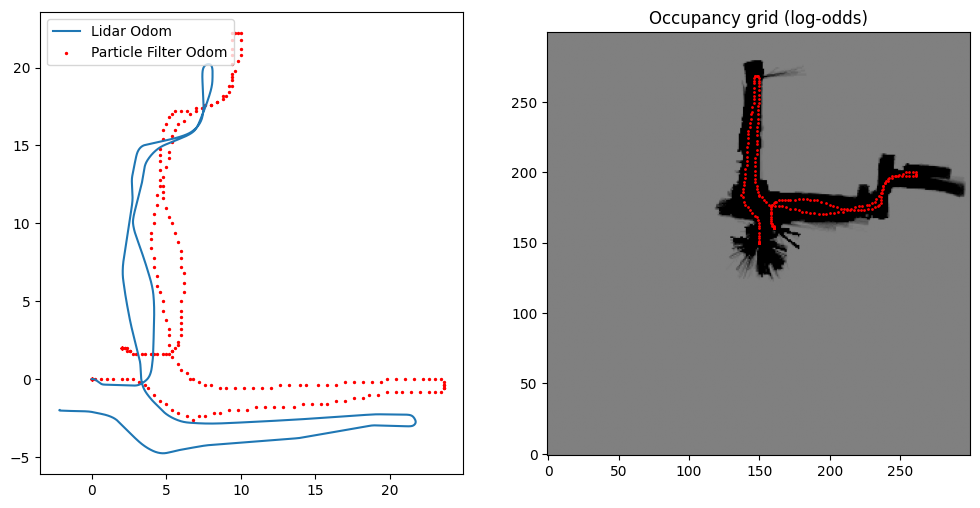

In [100]:
Map.plot(robot_pose, trajectory, f"../fig/grid_{data_version}_2")
